In [30]:
from algorithm import *
from model import *
import torch
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix
import pickle
from netrd.distance import netsimile
import networkx as nx
import os.path as osp
from scipy.sparse import coo_matrix
from tqdm import tqdm
import random
import warnings
from torch.optim import Adam
from utils import *
import argparse
warnings.filterwarnings("ignore")

In [31]:
# import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

In [32]:
def load_adj(dataset):
    if (dataset == "celegans"):
        S = torch.load("data/celegans.pt")
    elif(dataset == "arenas"):
        S = torch.load("data/arenas.pt")
    elif (dataset == "douban"):
        S = torch.load("data/douban.pt")
    elif(dataset == "Online"):
        S = torch.load("data/online.pt")
    elif(dataset == "Offline"):
        S = torch.load("data/offline.pt")
    elif (dataset == "ACM"):
        S = torch.load("data/ACM.pt")
    elif (dataset == "DBLP"):
        S = torch.load("data/DBLP.pt")
    else:
        filepath = "data/" + dataset + ".npz"
        loader = load_npz(filepath)
        data = loader["adj_matrix"]
        samples = data.shape[0]
        features = data.shape[1]
        values = data.data
        coo_data = data.tocoo()
        indices = torch.LongTensor([coo_data.row, coo_data.col])
        S = torch.sparse.FloatTensor(indices, torch.from_numpy(values).float(), [samples, features]).to_dense()
        if (not torch.all(S.transpose(0, 1) == S)):
            S = torch.add(S, S.transpose(0, 1))
        S = S.int()
        ones = torch.ones_like(S)
        S = torch.where(S > 1, ones, S)
    return S

In [33]:
dataset_ = "celegans"
model_ = "uniform"
level_ = 0.05

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
train_set = ["celegans","arenas","douban","cora"]
test_set = [dataset_]
probability_model = model_
training_perturbation_level = level_
no_training_samples_per_graph = 10 # change 10
NUM_HIDDEN_LAYERS = 8
HIDDEN_DIM = 16
output_feature_size = 8 # embedding size
lr = 0.001
epoch = 200

In [34]:
print("Loading training datasets")

train_loader = {}
original_graph_loader = {}
for dataset in [*set(train_set + test_set)]:
    original_graph_loader[dataset] = load_adj(dataset)

Loading training datasets


In [35]:
temp = original_graph_loader[dataset_]
print(temp.shape)
temp

torch.Size([453, 453])


tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [36]:
edge_index = temp.nonzero().t().contiguous()
edge_index

tensor([[  0,   0,   0,  ..., 450, 451, 452],
        [  1,   2,   3,  ..., 449, 107, 443]])

In [37]:
print("Generating training perturbations")
print(train_set)
for dataset in train_set:
    train_loader[dataset] = generate_purturbations(device, original_graph_loader[dataset],
                                                    perturbation_level = training_perturbation_level,
                                                    no_samples=no_training_samples_per_graph,
                                                    method = probability_model)

Generating training perturbations
['celegans', 'arenas', 'douban', 'cora']


In [38]:
temp = train_loader[dataset_]
print(len(temp), temp[0].shape)
temp[0]

10 torch.Size([453, 453])


tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [39]:
edge_index = temp[0].nonzero().t().contiguous()
edge_index

tensor([[  0,   0,   0,  ..., 450, 451, 452],
        [  1,   2,   3,  ..., 449, 107, 443]])

In [40]:
model = GAE(NUM_HIDDEN_LAYERS,
            7,
            HIDDEN_DIM,
            output_feature_size, activation=F.relu,
            use_input_augmentation=True,
            use_output_augmentation=False,
            encoder="GIN",variational=False).to(device)

In [41]:
print("Generating training features")
train_features = {}
for dataset in train_loader.keys():
    train_features[dataset] = generate_features(train_loader[dataset])

Generating training features


In [42]:
temp = train_features[dataset_]
print(len(temp), temp[0].shape)
temp[0]

10 torch.Size([453, 7])


tensor([[7.0000e+00, 6.6667e-01, 7.1714e+01,  ..., 2.1000e+01, 4.6700e+02,
         2.7000e+02],
        [1.1000e+01, 6.3636e-01, 6.4364e+01,  ..., 4.6000e+01, 6.2700e+02,
         3.1400e+02],
        [2.2800e+02, 2.7668e-02, 1.0443e+01,  ..., 9.4400e+02, 7.2100e+02,
         1.9800e+02],
        ...,
        [2.0000e+00, 1.0000e+00, 5.5000e+00,  ..., 3.0000e+00, 7.0000e+00,
         7.0000e+00],
        [1.0000e+00, 0.0000e+00, 2.0000e+00,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [1.0000e+00, 0.0000e+00, 4.0000e+00,  ..., 1.0000e+00, 3.0000e+00,
         3.0000e+00]])

In [43]:
print("Fitting T-GAE")
# fit_GAE(len(train_set)*(no_training_samples_per_graph+1),model,epoch, train_loader, train_features, device, lr, args.level, args.dataset, args.model)
no_samples = len(train_set) * (no_training_samples_per_graph + 1)
GAE = model
level_eval = level_
dataset_eval = dataset_
model_eval = model_

best_avg = 0
best_std = 0
S_hat_samples, S_prime_samples, p_samples = gen_test_set(device, load_adj(dataset_eval), 10,
                                                            [level_eval],
                                                            method=model_eval)
S_eval = load_adj(dataset_eval) # Adjency matrix of S
adj_S = coo_matrix(S_eval.numpy())
adj_norm_S = preprocess_graph(adj_S)
adj_norm_S = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_S[0].T),
                                    torch.FloatTensor(adj_norm_S[1]),
                                    torch.Size(adj_norm_S[2])).to(device)

S_feat = generate_features([S_eval])[0] # Features matrix of  S

S_hat_features = generate_features(S_hat_samples[str(level_eval)])
optimizer = Adam(GAE.parameters(), lr=lr,weight_decay=5e-4)
for step in range(epoch):
    loss = 0
    for dataset in train_loader.keys():
        S = train_loader[dataset][0]
        initial_features = train_features[dataset]
        for i in range(len(train_loader[dataset])):
            adj_tensor = train_loader[dataset][i]
            adj = coo_matrix(adj_tensor.numpy())
            adj_norm = preprocess_graph(adj)
            pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
            norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

            adj_label = coo_matrix(S.numpy())
            adj_label = sparse_to_tuple(adj_label)

            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T),
                                                torch.FloatTensor(adj_norm[1]),
                                                torch.Size(adj_norm[2])).to(device)
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T),
                                                torch.FloatTensor(adj_label[1]),
                                                torch.Size(adj_label[2])).to(device)

            initial_feature = initial_features[i].to(device)

            weight_mask = adj_label.to_dense().view(-1) == 1
            weight_tensor = torch.ones(weight_mask.size(0))
            weight_tensor[weight_mask] = pos_weight
            weight_tensor = weight_tensor.to(device)
            z = GAE(initial_feature, adj_norm)
            A_pred = torch.sigmoid(torch.matmul(z,z.t()))
            loss += norm * F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1),
                                                        weight=weight_tensor)
    optimizer.zero_grad()
    loss = loss / no_samples
    loss.backward()
    optimizer.step()
    print("Epoch:", '%04d' % (step + 1), "train_loss= {0:.5f}".format(loss.item()), end = " ")
    
    S_emb = GAE(S_feat.to(device), adj_norm_S).detach()
    avg, std, indices = test_matching(GAE, S_hat_samples[str(level_eval)], p_samples[str(level_eval)], 
                            S_hat_features, S_emb, device, metric="accuracy")
    
    if(avg > best_avg):
        best_avg = avg
        best_std = std
    print("Current best result:" +str(best_avg)[:6]+"+-"+str(best_std)[:5])

print(0, level_eval)
print("---")
x = S_hat_samples[str(level_eval)]
print(1, type(x), len(x), x[0].shape)
print("---")
x = p_samples[str(level_eval)]
print(2, type(x), len(x), x[0].shape)
print(indices)

Fitting T-GAE


Epoch: 0001 train_loss= 43.29527 Correct number of matchings is 0.4050+-0.1764

Current best result:0.4050+-0.176
Epoch: 0002 train_loss= 42.23001 Correct number of matchings is 0.4339+-0.1652

Current best result:0.4339+-0.165
Epoch: 0003 train_loss= 40.62729 Correct number of matchings is 0.4715+-0.1604

Current best result:0.4715+-0.160
Epoch: 0004 train_loss= 38.39247 Correct number of matchings is 0.4920+-0.1471

Current best result:0.4920+-0.147
Epoch: 0005 train_loss= 35.50525 Correct number of matchings is 0.5187+-0.1356

Current best result:0.5187+-0.135
Epoch: 0006 train_loss= 31.61768 Correct number of matchings is 0.5529+-0.1128

Current best result:0.5529+-0.112
Epoch: 0007 train_loss= 26.84867 Correct number of matchings is 0.5878+-0.0986

Current best result:0.5878+-0.098
Epoch: 0008 train_loss= 22.28672 Correct number of matchings is 0.5949+-0.0822

Current best result:0.5949+-0.082
Epoch: 0009 train_loss= 16.80930 Correct number of matchings is 0.6026+-0.0870

Current 

### Test

In [44]:
# test save matrix

# save
x = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
torch.save(x, 'data/A.pt')

# load
print(dataset_eval)
# S_eval = load_adj(dataset_eval)
S_eval = torch.load("data/A.pt")
print(S_eval.shape)
S_eval

celegans
torch.Size([3, 3])


tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [45]:
print(indices)
for k, item in enumerate(indices):
    print(k, len(item), item)

[[1, 5, 8, 9, 12, 13, 14, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 37, 38, 40, 45, 46, 47, 48, 50, 51, 52, 53, 56, 57, 60, 64, 65, 66, 67, 68, 69, 70, 71, 74, 78, 79, 82, 83, 84, 88, 89, 90, 92, 95, 98, 99, 101, 102, 105, 106, 107, 108, 110, 112, 113, 114, 118, 119, 120, 121, 123, 125, 127, 129, 130, 131, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 151, 152, 154, 156, 158, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 173, 175, 178, 180, 181, 182, 183, 185, 187, 188, 189, 192, 193, 194, 195, 197, 200, 202, 203, 204, 208, 211, 212, 213, 217, 219, 221, 222, 224, 226, 227, 228, 230, 232, 233, 234, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 252, 253, 254, 256, 257, 259, 261, 262, 263, 264, 266, 267, 268, 272, 274, 279, 281, 282, 285, 286, 288, 289, 291, 294, 298, 299, 301, 305, 308, 309, 310, 312, 314, 318, 320, 322, 323, 324, 325, 329, 332, 333, 334, 335, 336, 337, 338, 340, 341, 342, 343, 344, 345, 346, 347, 348, 34

Plot

In [46]:
# adj_norm_S, G1

adj_norm_S

tensor(indices=tensor([[  0,   1,   2,  ..., 451, 443, 452],
                       [  0,   0,   0,  ..., 451, 452, 452]]),
       values=tensor([0.1250, 0.1021, 0.0229,  ..., 0.5000, 0.3162, 0.5000]),
       device='cuda:0', size=(453, 453), nnz=4503, layout=torch.sparse_coo)

In [47]:
# adj_norm_S_hat, G2

S_hat_cur = S_hat_samples[str(level_eval)][0]
adj = coo_matrix(S_hat_cur.numpy())
adj_norm_S_hat = preprocess_graph(adj)
adj_norm_S_hat = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_S_hat[0].T),
                                    torch.FloatTensor(adj_norm_S_hat[1]),
                                    torch.Size(adj_norm_S_hat[2])).to(device)
adj_norm_S_hat

tensor(indices=tensor([[  0, 240, 248,  ..., 418, 426, 452],
                       [  0,   0,   0,  ..., 452, 452, 452]]),
       values=tensor([0.1667, 0.0475, 0.1543,  ..., 0.0393, 0.1508, 0.0909]),
       device='cuda:0', size=(453, 453), nnz=4389, layout=torch.sparse_coo)

torch.Size([2, 4503])
tensor([[  0,   0,   0,  ..., 451, 452, 452],
        [  0,   1,   2,  ..., 451, 443, 452]], device='cuda:0')
453 2025


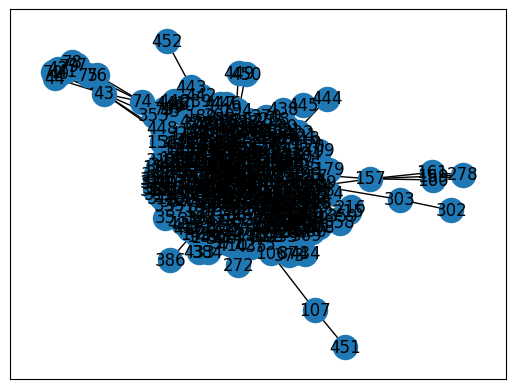

In [48]:
temp = adj_norm_S.coalesce().indices()
print(temp.shape)
print(temp)

G1 = nx.from_edgelist(temp.T.cpu().numpy())
G1.remove_edges_from(nx.selfloop_edges(G1))
print(G1.number_of_nodes(), G1.number_of_edges())

pos = nx.spring_layout(G1)
nx.draw_networkx(G1, pos=pos)

torch.Size([2, 4389])
tensor([[  0,   0,   0,  ..., 452, 452, 452],
        [  0, 240, 248,  ..., 418, 426, 452]], device='cuda:0')
453 1968


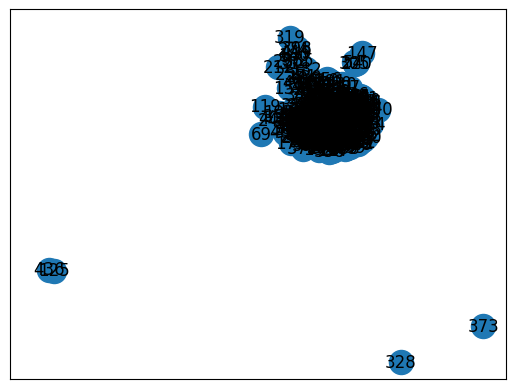

In [49]:
temp = adj_norm_S_hat.coalesce().indices()
print(temp.shape)
print(temp)

G2 = nx.from_edgelist(temp.T.cpu().numpy())
G2.remove_edges_from(nx.selfloop_edges(G2))
print(G2.number_of_nodes(), G2.number_of_edges())

nx.draw_networkx(G2)

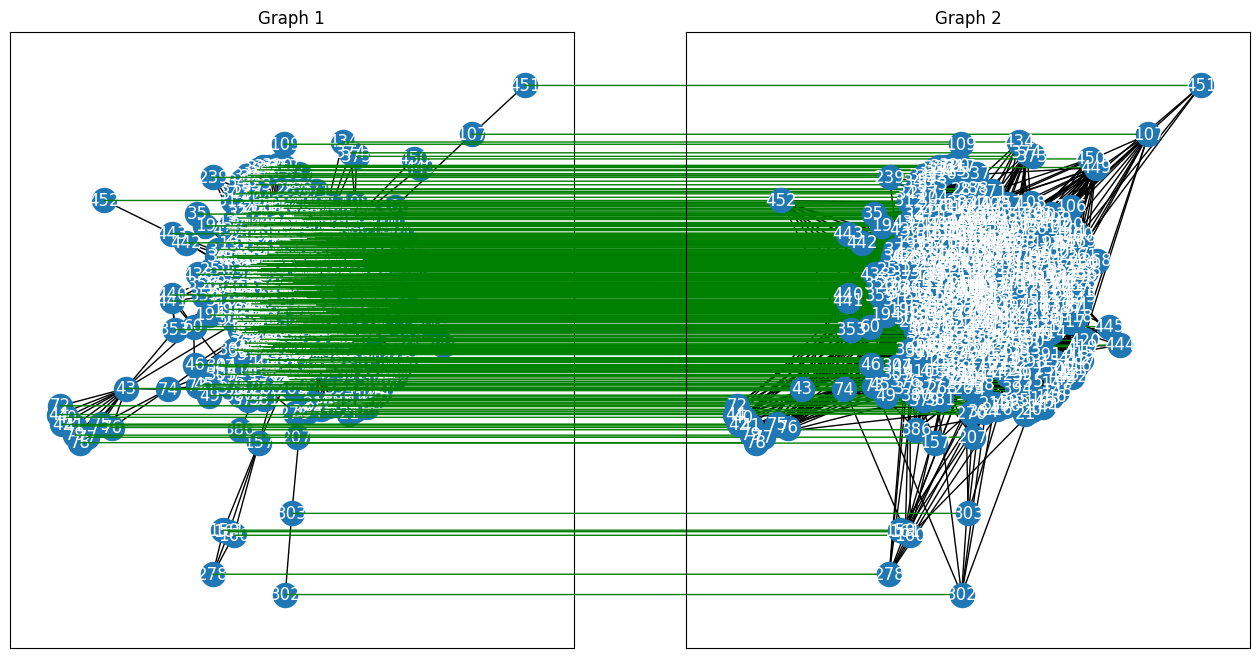

In [50]:
pos1 = nx.spring_layout(G1)
pos2 = nx.spring_layout(G2)

plt.figure(figsize=(16, 8))
ax1 = plt.subplot(1, 2, 1)
plt.title('Graph 1')
nx.draw_networkx(G1, pos=pos1, font_color="w")
ax2 = plt.subplot(1, 2, 2)
plt.title('Graph 2')
nx.draw_networkx(G2, pos=pos1, font_color="w")

# add connections
for i in range(len(pos1)):
    con = ConnectionPatch(xyA=pos1[i], xyB=pos1[i], coordsA=ax1.transData, coordsB=ax2.transData, arrowstyle="-", color="green")
    ax2.add_artist(con)
plt.show()